In [61]:
from log import logger
logger.info('Importing libraries...')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#import the neccessary module
from helper import Model
from helper import Auxiliary
# Modelling
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

2023-03-24 20:56:58,694 -     INFO - Importing libraries... (2238536406.py:2)


Get train test data


In [72]:
#df_train, df_test = Auxiliary.train_test_split(Auxiliary.preprocess_data(Model.get_csv('BPI_Challenge_2012.csv')))
logger.info('Reading data...')
df_train = Model.get_csv('train.csv')
df_test = Model.get_csv('test.csv')

#only select needed columns
logger.info("Selecting columns:'case:concept:name', 'concept:name', 'time:timestamp', 'Next Time', 'lifecycle:transition'")
df_train = df_train[['case:concept:name', 'concept:name', 'time:timestamp', 'Next Time', 'lifecycle:transition']]
df_test = df_test[['case:concept:name', 'concept:name', 'time:timestamp', 'Next Time', 'lifecycle:transition']]

#remove entries where there is NaN
logger.info('Removing NaN values...')
df_train = df_train.dropna()
df_test = df_test.dropna()
df_train = df_train.replace(-1, 0)
df_test = df_test.replace(-1, 0)

#eliminate outliers
logger.info('Eliminating outliers...')
q__train_low = df_train["Next Time"].quantile(0.03)

q__train_hi  = df_train["Next Time"].quantile(0.99)

#df_train = df_train[df_train["Next Time"] < q__train_hi]
q_test_low = df_test["Next Time"].quantile(0.01)
q_test_hi = df_test["Next Time"].quantile(0.99)
df_test = df_test[(df_test["Next Time"] < q_test_hi) & (df_test["Next Time"] > q_test_low)]
# df_test = df_test[df_test["Next Time"] < q_test_hi]

df_train = df_train[(df_train["Next Time"] < q__train_hi) & (df_train["Next Time"] > q__train_low)]

#One hot encoding of the activities
logger.info('One hot encoding of the activities...')
df_train['concept:name'] = df_train['concept:name'].apply(lambda x: Auxiliary.one_hot_encode(x, 24))
df_test['concept:name'] = df_test['concept:name'].apply(lambda x: Auxiliary.one_hot_encode(x, 24))


from datetime import datetime
#get week day from timestamp and hot encode it
logger.info('Pulling the week day from the timestamp and hot encoding it...')
df_train['time:timestamp'] = pd.to_datetime(df_train['time:timestamp'])

df_train['Week Day'] = df_train['time:timestamp'].apply(lambda x: x.strftime('%w'))

df_train['Week Day'] = df_train['Week Day'].apply(lambda x: Auxiliary.one_hot_encode(int(x), 7))

df_test['time:timestamp'] = pd.to_datetime(df_test['time:timestamp'])

df_test['Week Day'] = df_test['time:timestamp'].apply(lambda x: int(x.strftime('%w')))

df_test['Week Day'] = df_test['Week Day'].apply(lambda x: Auxiliary.one_hot_encode(int(x), 7))

#drop timestamp
logger.info('Dropping timestamp...')
df_train.drop(['time:timestamp'], axis=1, inplace=True)
df_test.drop(['time:timestamp'], axis=1, inplace=True)

#encode lifecycle:transition
logger.info('Encoding lifecycle:transition...')
df_train['lifecycle:transition'] = df_train['lifecycle:transition'].apply(lambda x: Auxiliary.one_hot_encode(x, df_train['lifecycle:transition'].nunique()))
df_test['lifecycle:transition'] = df_test['lifecycle:transition'].apply(lambda x: Auxiliary.one_hot_encode(x, df_test['lifecycle:transition'].nunique()))

2023-03-24 21:03:49,589 -     INFO - Reading data... (2686146794.py:2)
2023-03-24 21:03:49,726 -     INFO - Selecting columns:'case:concept:name', 'concept:name', 'time:timestamp', 'Next Time', 'lifecycle:transition' (2686146794.py:7)
2023-03-24 21:03:49,733 -     INFO - Removing NaN values... (2686146794.py:12)
2023-03-24 21:03:49,744 -     INFO - Eliminating outliers... (2686146794.py:19)
2023-03-24 21:03:49,755 -     INFO - One hot encoding of the activities... (2686146794.py:33)
2023-03-24 21:03:49,862 -     INFO - Pulling the week day from the timestamp and hot encoding it... (2686146794.py:40)
2023-03-24 21:03:50,249 -     INFO - Dropping timestamp... (2686146794.py:54)
2023-03-24 21:03:50,255 -     INFO - Encoding lifecycle:transition... (2686146794.py:59)


Encode the concept:name

In [73]:
#x_train = df_train[['org:resource', 'lifecycle:transition','concept:name','case:AMOUNT_REQ','month', 'day']]
logger.info('Splitting data into x and y...')
x_train = df_train[['concept:name', 'lifecycle:transition', 'Week Day']]
y_train = df_train[['Next Time']]
#x_test = df_test[['org:resource', 'lifecycle:transition','concept:name','case:AMOUNT_REQ','month', 'day']]
x_test = df_test[['concept:name' , 'lifecycle:transition', 'Week Day']]
y_test = df_test[['Next Time']]

2023-03-24 21:04:17,318 -     INFO - Splitting data into x and y... (4105737707.py:2)


In [64]:
print(x_train.shape)
print(y_train.shape)

(38862, 3)
(38862, 1)


Normalizing y values 

In [74]:
#normalize y values

split_location = y_train.shape[0]
logger.info('Normalizing y values...')
y_df = pd.concat([y_train, y_test])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(y_df)

y_df = scaler.transform(y_df)

#Resplit as numpy arrays
y_train = y_df[0:split_location]
y_test = y_df[split_location:]

x_train = x_train.values
x_test = x_test.values

2023-03-24 21:04:48,935 -     INFO - Normalizing y values... (700907669.py:4)


In [66]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(38862, 3) (38862, 1) (17201, 3) (17201, 1)


In [75]:
logger.info('Reshaping x values from 3D to 2D...')
temp_array = []
real_x_train = []
real_x_test = []
for index,value in enumerate(x_train):
    temp_array = []
    temp_array = value[0]
    temp_array = np.append(temp_array, value[1])
    temp_array = np.append(temp_array, value[2])
    real_x_train.append(temp_array)
for index,value in enumerate(x_test):
    temp_array = []
    temp_array = value[0]
    temp_array = np.append(temp_array, value[1])
    temp_array = np.append(temp_array, value[2])
    real_x_test.append(temp_array)

logger.info('Reshaping y values from 2D to 1D...')
real_y_train = []
real_y_test = []
for index,value in enumerate(y_train):
    real_y_train.append(value[0])
for index,value in enumerate(y_test):
    real_y_test.append(value[0])

y_train = np.array(real_y_train)
y_test = np.array(real_y_test)

x_train = np.array(real_x_train)
x_test = np.array(real_x_test)

2023-03-24 21:05:38,225 -     INFO - Reshaping x values from 3D to 2D... (3610226961.py:1)
2023-03-24 21:05:38,587 -     INFO - Reshaping y values from 2D to 1D... (3610226961.py:18)


RFR Hyperparameter optimizer through grid search

In [ ]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

RFR_space = {'criterion': hp.choice('criterion', ['squared_error', 'absolute_error', 'poisson', 'friedman_mse']),
             'max_depth': hp.choice('max_depth', range(1, 10)),
             'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
             'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
             'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
             'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
             'max_leaf_nodes': hp.choice('max_leaf_nodes', range(2, 10)),
             'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.5),
             'verbose': 1,
             'n_jobs': None
             }
def RFR_objective(space):
    model = RandomForestRegressor(**space)
    accuracy = cross_val_score(model, x_train, y_train, cv = 5).mean()
    return {'loss': -accuracy, 'status': STATUS_OK}
    
trials = Trials()

best_RFR = fmin(fn = RFR_objective,
            space = RFR_space,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trials)


best_RFR

'criterion' : 'friedman_mse'
'max_depth' : 9
'max_features': 'log2'
'max_leaf_nodes' : 6
'min_impurity_decrease' : 0.3345
'min_samples_leaf' : 5
'min_samples_split' : 5
'min_weight_fraction_leaf': 0.000216


In [76]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(criterion = 'friedman_mse',
                                max_depth = 9,
                                max_features= 'log2',
                                max_leaf_nodes= 6,
                                min_impurity_decrease= 0.3345,
                                min_samples_leaf= 5,
                                min_samples_split= 5,
                                min_weight_fraction_leaf= 0.000216,
                                )

model = regr.fit(x_train, y_train)

regr2 = RandomForestRegressor()

model2 = regr2.fit(x_train, y_train)


y_test_pred = model.predict(x_test)
y_2_test_pred = model2.predict(x_test)

#save 
import sklearn.metrics as sm
import scipy.stats as stats

print("Grid searched RFR hyperparameters metrics")
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))
print("Z score =",  np.average(stats.zscore(y_test_pred)))
print('\n')
print("No hyperparameters RFR metrics")
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_2_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_2_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_2_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_2_test_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_2_test_pred), 2))
print("Z score =",  np.average(stats.zscore(y_2_test_pred)))


Grid searched RFR hyperparameters metrics
Mean absolute error = 0.06
Mean squared error = 0.02
Median absolute error = 0.02
Explain variance score = -0.01
R2 score = -0.02
Z score = 6.085417725068386e-18


No hyperparameters RFR metrics
Mean absolute error = 0.05
Mean squared error = 0.02
Median absolute error = 0.0
Explain variance score = -0.12
R2 score = -0.15
Z score = -1.2404889978024017e-17


In [77]:
print(y_test_pred)
print(y_test)

[0.02122224 0.01962406 0.01396642 ... 0.00805232 0.02787297 0.00805232]
[1.61209733e-07 1.44864857e-05 9.54231307e-03 ... 1.85994535e-03
 7.25136535e-01 2.42501233e-05]


In [82]:
RFR_difference = y_test_pred - y_test
print(RFR_difference)

[ 0.02122208  0.01960958  0.00442411 ...  0.00619238 -0.69726357
  0.00802807]


[ 0.02122208  0.01960958  0.00442411 ...  0.00619238 -0.69726357
  0.00802807]


c:\Users\Cristian\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


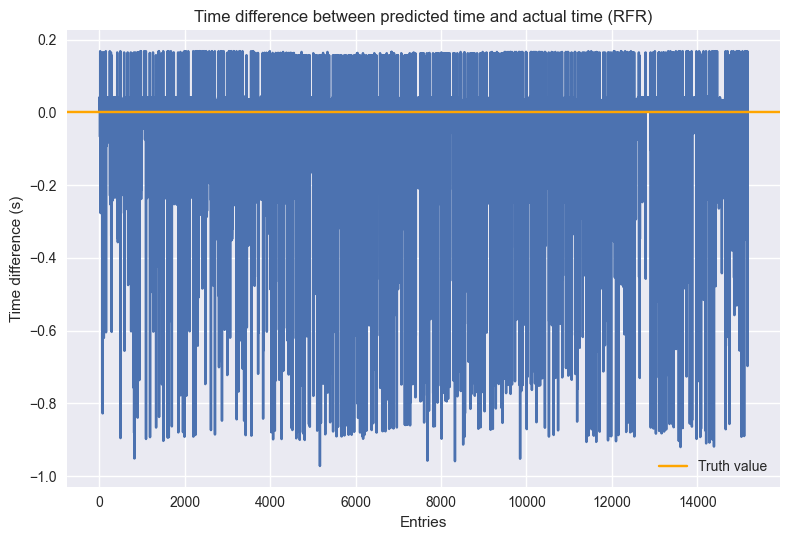

In [83]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig = plt.figure()
ax = plt.axes()

data_to_plot = RFR_difference
#remove nan values
#remove outliers from data
#data_to_plot = data_to_plot[data_to_plot.between(data_to_plot.quantile(.5), data_to_plot.quantile(.95))]

print(data_to_plot)

# plot normally
plt.rcParams["figure.figsize"] = [10.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.axhline(y=0, color='orange', linestyle='-', zorder=2)
plt.plot(data_to_plot, zorder=1)
plt.legend(['Truth value',], loc='lower right', )

plt.title('Time difference between predicted time and actual time (RFR)')
plt.xlabel('Entries')
plt.ylabel('Time difference (s)')
plt.show()


In [28]:
clear_session()

In [11]:
print(x_train[4])

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]


In [80]:
import numpy as npimport
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR

regressor = SVR(kernel = 'rbf')
regressor.fit(x_train, y_train)
svm_y_test = regressor.predict(x_test)

import sklearn.metrics as sm
import scipy.stats as stats

print("SVM metrics")
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, svm_y_test), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, svm_y_test), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, svm_y_test), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, svm_y_test), 2)) 
print("R2 score =", round(sm.r2_score(y_test, svm_y_test), 2))
print("Z score =",  np.average(stats.zscore(svm_y_test)))

SVM metrics
Mean absolute error = 0.11
Mean squared error = 0.02
Median absolute error = 0.09
Explain variance score = -0.05
R2 score = -0.18
Z score = 2.808654334646947e-16


In [84]:
SVM_difference = svm_y_test - y_test

[ 0.10022878  0.09998128  0.05483661 ...  0.0981627  -0.62488328
  0.08118936]


c:\Users\Cristian\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


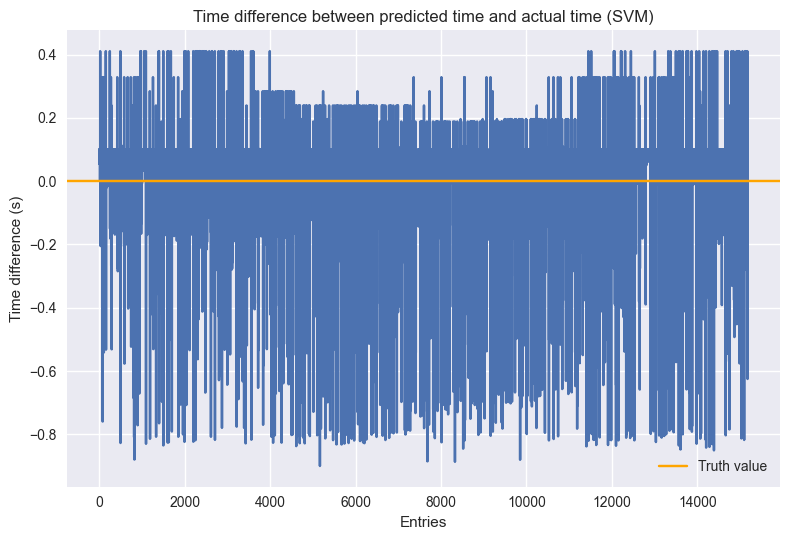

In [86]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig = plt.figure()
ax = plt.axes()

data_to_plot = SVM_difference
#remove nan values
#remove outliers from data
#data_to_plot = data_to_plot[data_to_plot.between(data_to_plot.quantile(.5), data_to_plot.quantile(.95))]

print(data_to_plot)

# plot normally
plt.rcParams["figure.figsize"] = [10.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.axhline(y=0, color='orange', linestyle='-', zorder=2)
plt.plot(data_to_plot, zorder=1)
plt.legend(['Truth value',], loc='lower right', )

plt.title('Time difference between predicted time and actual time (SVM)')
plt.xlabel('Entries')
plt.ylabel('Time difference (s)')
plt.show()


In [87]:

# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

In [88]:
clear_session()

In [89]:
# create ANN model
model = Sequential()
model.add(layers.Dense(10, input_dim=x_train.shape[1], activation='relu'))
model.add(layers.Dense(4))


model.add(layers.Dense(1, activation='sigmoid'))


#model.compile(loss = 'binary_crossentropy', optimizer='rmsprop' metrics = ['accuracy'], )
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])



In [91]:
# Fitting the ANN to the Training set
history = model.fit(x_train, y_train, batch_size=10, epochs=20, verbose= 1, validation_data=(x_test, y_test))

Epoch 1/20
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0893 - accuracy: 0.0115 - val_loss: 0.2580 - val_accuracy: 0.0099
Epoch 2/20
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0890 - accuracy: 0.0115 - val_loss: 0.2479 - val_accuracy: 0.0099
Epoch 3/20
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0887 - accuracy: 0.0115 - val_loss: 0.2729 - val_accuracy: 0.0099
Epoch 4/20
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0884 - accuracy: 0.0115 - val_loss: 0.2842 - val_accuracy: 0.0099
Epoch 5/20
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0883 - accuracy: 0.0115 - val_loss: 0.2666 - val_accuracy: 0.0099
Epoch 6/20
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0884 - accuracy: 0.0115 - val_loss: 0.2735 - val_accuracy: 0.0099
Epoch 7/20
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0882 - accuracy: 0.0115 - val_loss: 0.2792 - val_accuracy:

In [93]:
nn_y_test = model.predict(x_test)

print("NN metrics")
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, nn_y_test), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, nn_y_test), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, nn_y_test), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, nn_y_test), 2)) 
print("R2 score =", round(sm.r2_score(y_test, nn_y_test), 2))
print("Z score =",  np.average(stats.zscore(nn_y_test)))

475/475 [==============================] - 0s 648us/step
NN metrics
Mean absolute error = 0.05
Mean squared error = 0.02
Median absolute error = 0.0
Explain variance score = -0.1
R2 score = -0.12
Z score = -3.490125e-08


In [105]:
print(type(nn_y_test))

<class 'list'>


In [107]:
nn_y_test = np.array(nn_y_test)

In [109]:
print(nn_y_test)

<class 'numpy.ndarray'>


In [108]:
real_nn_y_test = []
for entry in nn_y_test:
    real_nn_y_test.append(entry[0])
nn_y_test = real_nn_y_test
print(nn_y_test)

IndexError: invalid index to scalar variable.

In [101]:
NN_difference = nn_y_test - y_test
print(NN_difference.shape)
print(type(NN_difference))

(15179, 15179)
<class 'numpy.ndarray'>


[[ 1.22130009e-06 -1.31039759e-05 -9.54093056e-03 ... -1.85856284e-03
  -7.25135153e-01 -2.28676135e-05]
 [ 7.80586525e-05  6.37333765e-05 -9.46409321e-03 ... -1.78172549e-03
  -7.25058315e-01  5.39697389e-05]
 [-1.01525806e-07 -1.44268018e-05 -9.54225339e-03 ... -1.85988567e-03
  -7.25136476e-01 -2.41904394e-05]
 ...
 [ 1.48059780e-03  1.46627252e-03 -8.06155407e-03 ... -3.79186347e-04
  -7.23655776e-01  1.45650888e-03]
 [ 3.65348001e-02  3.65204748e-02  2.69926482e-02 ...  3.46750160e-02
  -6.88601574e-01  3.65107112e-02]
 [ 1.38053859e-03  1.36621332e-03 -8.16161327e-03 ... -4.79245549e-04
  -7.23755835e-01  1.35644968e-03]]


KeyboardInterrupt: 

c:\Users\Cristian\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


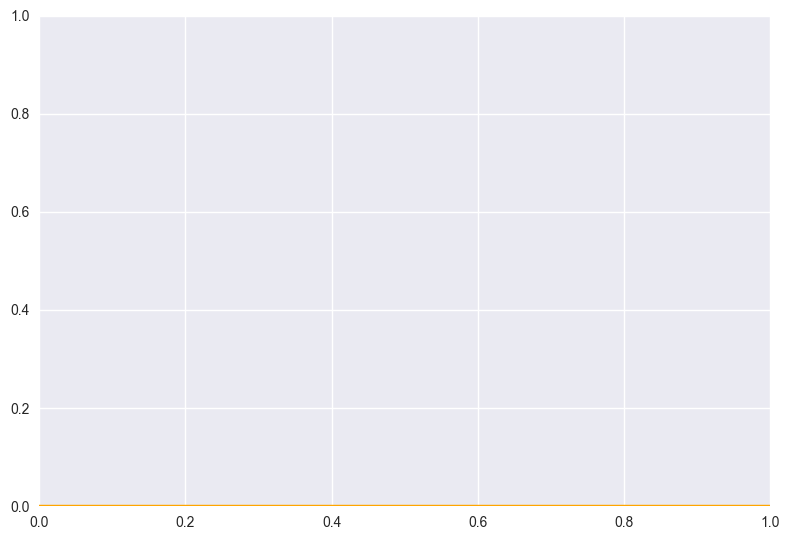

In [99]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig = plt.figure()
ax = plt.axes()

data_to_plot = NN_difference
#remove nan values
#remove outliers from data
#data_to_plot = data_to_plot[data_to_plot.between(data_to_plot.quantile(.5), data_to_plot.quantile(.95))]

print(data_to_plot)

# plot normally
plt.rcParams["figure.figsize"] = [10.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.axhline(y=0, color='orange', linestyle='-', zorder=2)
plt.plot(data_to_plot, zorder=1)
plt.legend(['Truth value',], loc='lower right', )

plt.title('Time difference between predicted time and actual time (NN)')
plt.xlabel('Entries')
plt.ylabel('Time difference (s)')
plt.show()


In [94]:
loss_and_accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Loss and Accuracy:", loss_and_accuracy)

loss_and_accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Loss and Accuracy:", loss_and_accuracy)

Training Loss and Accuracy: [0.08797404170036316, 0.011505812406539917]
Testing Loss and Accuracy: [0.26555734872817993, 0.009947954677045345]


c:\Users\Cristian\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


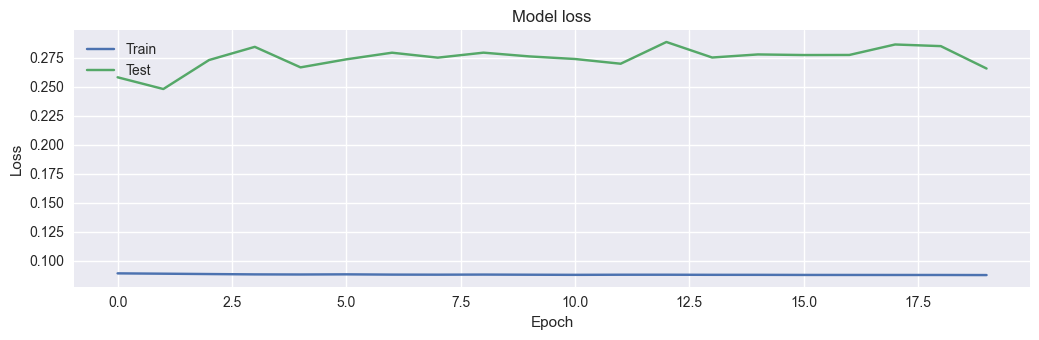

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [96]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(x_train, y_train, x_test, y_test):
    
    # Defining the list of hyper parameters to try
    #batch_size_list=[5, 10, 15, 20]
    batch_size_list=[5,10]
    #epoch_list  =   [5, 10, 50, 100]
    epoch_list = [5,10]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')
 
            # Fitting the ANN to the Training set
            model.fit(x_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            error = y_test-model.predict(x_test)
            error = np.nan_to_num(error, nan=0, posinf=0, neginf=0)
            MAPE = np.mean(100 * (np.abs(error) / y_test))

            
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)

In [ ]:
print(y_train)

In [ ]:
# Calling the function
ResultsData=FunctionFindBestParams(x_train, y_train, x_test, y_test)

In [ ]:
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')